# Cross-correlation and Requirements for Approaching Unbiased Estimator CRB Limits

Cross-correlation and generalized cross-correlation is often used to estimate TDOA in passive sensor scenarios, with no prior knowledge of the signal (blind estimation).
In such cases, we would like to find out which factors affect the bias of the estimate, and the degree to which it approaches the unbiased estimator CRB limit, if any.

Let's start by creating a short signal and performing the generalized cross-correlation to scan subsample TDOA. We will not use any noise here, so we would expect the results to be perfect or near perfect.

Note that we generate the received signal using a highly super-sampled version of the original signal, and then interpolate from that to 'receive' a reasonable sample rate version of the signal at our 'receivers'.

Signal duration = 0.100000s.
Tau1 = 0.000000s
Tau2 = 0.000150s
Sample-level time resolution = 0.000500s


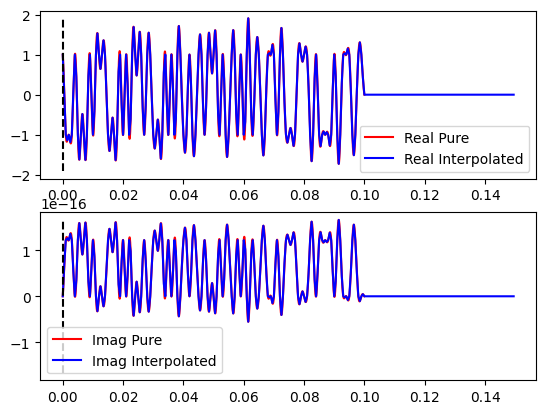

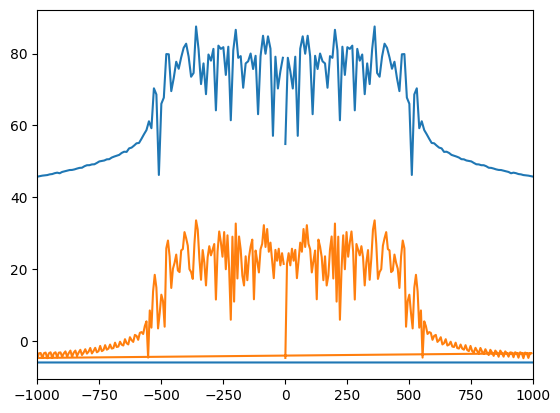

In [1]:
from signalCreationRoutines import *
from plotRoutines import *

import scipy.signal as sps

# Parameters
length = 100
baud = 1000
m = 2
duration = length/baud
print("Signal duration = %fs." % (duration))

# Pure, high oversampled version of the signal
pure_OSR = 1000
pure_fs = pure_OSR * baud

# Sample rates at receiver
fs_OSR = 2
fs = fs_OSR * baud
ftap = sps.firwin(64, baud/fs)

tau1 = 0.0 / fs
tau2 = 0.3 / fs

t = np.arange(int((1.5 * length / baud) * fs)) / fs

# Main generation function
def test_generate(length, baud, m, duration,
                  pure_OSR, pure_fs,
                  t,
                  tau1, tau2):
    
    # Create some symbols
    syms, bits = randPSKsyms(length, m)

    # Resample to a high OSR to allow interpolation
    sig = sps.resample_poly(syms, pure_OSR, 1)
    tp = np.arange(sig.size) / pure_fs

    # Sample the signal at a reasonable OSR, to two receivers
    rx1 = np.interp(t-tau1, tp, sig, left=0, right=0)
    rx2 = np.interp(t-tau2, tp, sig, left=0, right=0)

    return syms, sig, tp, rx1, rx2

# Generate once to test
syms, sig, tp, rx1, rx2 = test_generate(length, baud, m, duration,
                                        pure_OSR, pure_fs,
                                        t,
                                        tau1, tau2)

# Plot the signal?
fig, ax = plt.subplots(2,1)
ax[0].plot(tp, np.real(sig), 'r-', label='Real Pure')
ax[1].plot(tp, np.imag(sig), 'r-', label='Imag Pure')

ax[0].plot(t, np.real(rx1), 'b-', label='Real Interpolated')
ax[1].plot(t, np.imag(rx1), 'b-', label='Imag Interpolated')

ax[0].vlines(tau1, 
             -np.max(np.abs(np.real(rx1))), 
             np.max(np.abs(np.real(rx1))), 
             color='k', linestyle='dashed')
ax[1].vlines(tau1, 
             -np.max(np.abs(np.imag(rx1))), 
             np.max(np.abs(np.imag(rx1))), 
             color='k', linestyle='dashed')
ax[0].legend()
ax[1].legend()

print("Tau1 = %fs" % (tau1))
print("Tau2 = %fs" % (tau2))
print("Sample-level time resolution = %fs" % (1/fs))

sfig, sax = plotSpectra([sig, rx1], [pure_fs, fs])
sax.set_xlim((-baud, baud))

plt.show()


Estim. td = 0.0001516s
Actual td = 0.00015s
Estim err = 1.6e-06s


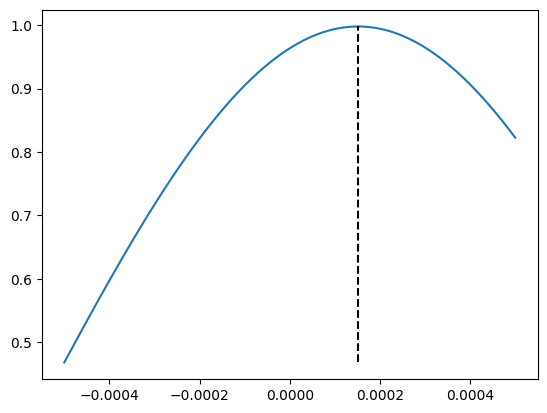

In [2]:
from xcorrRoutines import *

def test_estimate(rx1, rx2, duration, fs, td_scan_range, steeringvec=None, paddedLen=None):
    # Perform subsample time search i.e. generalised xcorr
    x_aligned = rx1[:int(duration*fs)]
    y_aligned = rx2[:int(duration*fs)] # We assume it's sample-aligned already

    if paddedLen is not None:
        x_aligned = np.hstack((x_aligned, np.zeros(paddedLen-len(x_aligned))))
        y_aligned = np.hstack((y_aligned, np.zeros(paddedLen-len(y_aligned))))

    finefreqfound, timediff, cost_vec = fineFreqTimeSearch(
        x_aligned, y_aligned,
        [], None, None, fs,
        td_scan_range, steeringvec=steeringvec)
    
    return timediff, cost_vec

# Test estimation once
td_scan_range = np.arange(-1/fs, 1/fs, 50e-9)
timediff, cost_vec = test_estimate(rx1, rx2, duration, fs, td_scan_range)

print("Estim. td = %gs" % (timediff))
print("Actual td = %gs" % (tau2-tau1))
print("Estim err = %gs" % (timediff - (tau2-tau1)))

plt.figure()
plt.plot(td_scan_range, np.abs(cost_vec))
plt.vlines(timediff, np.min(np.abs(cost_vec)), np.max(np.abs(cost_vec)), color='k', linestyle='dashed')

In [3]:
# Okay let's run it a few loops and collect results
from tqdm import tqdm

numIter = 500
timedifflist = np.zeros(numIter)

td_scan_range = np.arange(-0.5/fs, 0.5/fs, 100e-9)
steeringvec = makeTimeScanSteervec(td_scan_range, fs, int(duration*fs))
for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    timediff, cost_vec = test_estimate(rx1, rx2, duration, fs, td_scan_range, steeringvec=steeringvec)
    timedifflist[i] = timediff

100%|██████████| 500/500 [00:07<00:00, 69.96it/s]


Maximum TD abs error:  4.000000000009828e-06
Mean TD abs error:  1.8844000000095818e-06


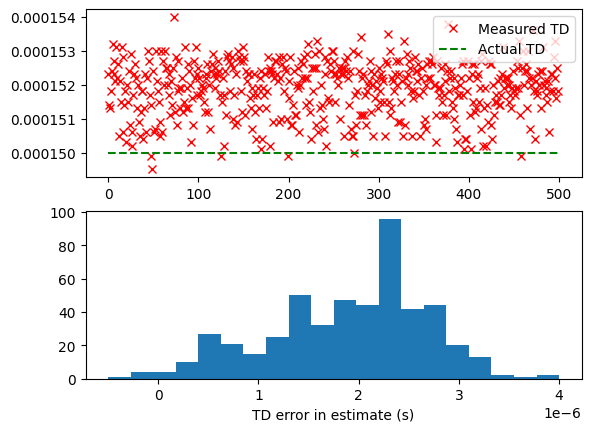

In [4]:
# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))
# efig.savefig("%g_%g.png" % (tau1, tau2))

## Biased Errors

What's going on here? It seems like the generalised cross-correlation estimator is returning a biased TD result, even in a noiseless scenario. You can try to change the ```tau``` values and other parameters, but you'll see that you will still get some variant of a biased result. There is also ample search range (you can uncomment the line to see where the TD scan range limits are) How do we fix this?

100%|██████████| 500/500 [00:07<00:00, 69.50it/s]


Maximum TD abs error:  2.699999999990335e-06
Mean TD abs error:  7.249999999984607e-07


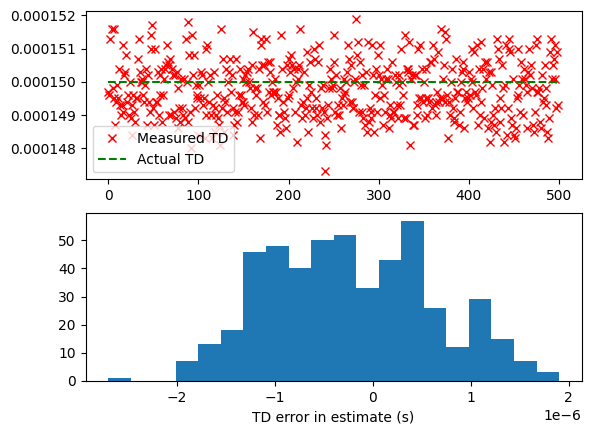

In [5]:
# Repeat the test, but add filtering before estimation (even though it's noiseless)
from tqdm import tqdm

numIter = 500
timedifflist = np.zeros(numIter)

td_scan_range = np.arange(-0.5/fs, 0.5/fs, 100e-9)
steeringvec = makeTimeScanSteervec(td_scan_range, fs, int(duration*fs))
for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    # Some filtering
    rx1 = sps.lfilter(ftap, 1, rx1)[ftap.size//2:]
    rx2 = sps.lfilter(ftap, 1, rx2)[ftap.size//2:]
    
    timediff, cost_vec = test_estimate(rx1, rx2, duration, fs, td_scan_range, steeringvec=steeringvec)
    timedifflist[i] = timediff

# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))

Okay, not exactly normally distributed, but at least it is more centred now, and the mean error is lower.

There's a clear issue here that we have forgotten: subsample searches using the generalised cross-correlation method relies on the FFT of the array used, and this inevitably affects the time resolution(?)/accuracy(?) of the subsample scan. This can be seen by considering the fact that a zero-padded array will have more frequency bins, and as such will have more frequency bins 'representing' the signal.